<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Home work - SOLUTIONS<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number:
<br>Group member1:
<br>Group member2:
<br>Group member3:

# Ex1. Fit data to sigmoid curve

<font size = "3">Fit the data in Sigmoid.dat file located in your group folder. 

<font size = "3">The function of a sigmoid is:
\begin{equation}  
    y = \frac {1}{(1 + e^{(\frac{x - vh}{-slope})})}
\end{equation}
    
<font size = "3">Show the data and the fitted curve on the same plot (as it was done in tutorial 1), label the axes and create a leyend to differenciate data from fitted curve. [0.5 pts]

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x, vh, slope):
    exponent = (x-vh)/-slope
    denum = 1 + np.exp(exponent)
    return 1/denum

In [3]:
def fit_curve(x, y):
    ''' fit an exponential curve to data '''
    
    popt, pcov = curve_fit(sigmoid, x, y)
    perr = np.sqrt(np.diag(pcov))
    
    
    plt.figure(figsize=(10,6))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x, y, 'or', label='original data' )
    plt.plot(x, sigmoid(x, *popt), '-b',label='fit: vh=%.3f, slope=%.3f, vh_error=%.3f, slope_error=%.3f' %(*popt,*perr))
    plt.legend()
    plt.show()

In [ ]:
# reda the data
fileName = './Group7/Sigmoid.dat'
df = pd.read_table(fileName, sep='\s+', header=None)
x_data = df[0]
y_data = df[1]

fit_curve(x_data, y_data)

# Ex2. Analysing an activation curve.

<font size = "3">Using the .NWB file in your folder group, fit each of the traces between 100 ms and the maximum amplitud of the trace to an exponential. The resulting tau from each fitting will be the time constant of the channel at the different voltage steps, which is related with how long it takes for the channel to open. Considering that the clamped voltage stimulation is -90 to +80 mV with 10mV step interval, represent in a plot time constant against clamped voltage. [2 pts]

In [6]:
# the files might not have 18 voltage step 
# so don't plot from -90 start at -30
import h5py

In [7]:
def read_trace_from_nwd(nwbFile, protocolName, repID):
    '''    read data
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number'''
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)][()]
    x_interval = open_data[(string_xinterval)][()]
    x_start = open_data[(string_xstart)][()]
    
    return data, x_interval, x_start

In [8]:
def create_time_vector(shape, x_start, x_interval):
    '''create time vector in ms '''
    
    # create time vector in ms
    nRow, nCol = shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    return time

In [34]:
def plot_one_trace(data, x_interval, x_start, column, title='TITLE', with_selection=False):
    ''' plot the trace
    :param column: the column of the single trace to plot
    :param with_selection: do the appropriate selection
    
    plot the trace with the selections necessary'''
    
    # get time in msec
    time = create_time_vector(data.shape, x_start, x_interval)
    
    # select the appropriate trace
    data = data[:,column]
    
    
    # do the 100 msec and max peak selection
    if with_selection:
        data, time = select(data,time)
    
    # is selection performed (used in title)
    selection = 'with selection' if with_selection else 'without selection'
    
    # plot the trace
    plt.figure()
    plt.title('%s protocol %s' %(title, selection))
    plt.ylabel('Activation trace')
    plt.xlabel('time (ms)')
    plt.plot(time, data, '.b')
    plt.show()
 

In [35]:
def select(data, time):
    '''select from 100 msec to the first big fall down'''
    
    # choose start at 100 msec
    # note the time is already in msec
    index_mask = (time>=100).ravel() # ravel to a row array
    data = data[index_mask]
    time = time[index_mask]
    
    
    # to find the drop
    # find the max - last value (last value looks like a god base line in plots)
    # find the first drop that is more than 1/2 of this value
    thresh = 1/2 * (np.max(data) - data[-1])
    for i, d in enumerate(data):
        if (i+1<len(data)) and ((d - data[i+1]) > thresh ):
            end = i
            break
    
    time = time[:end]
    data = data[:end]
    
    
    return data, time

We can see the trace before and after selection

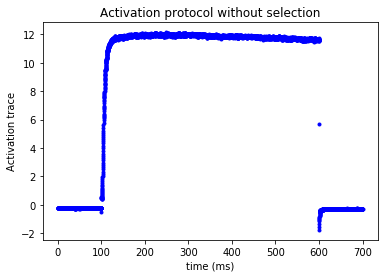

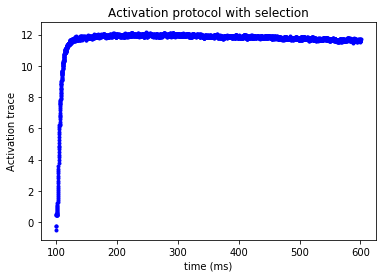

In [36]:
data_path = 'Group7/rCell9699.nwb'

data, x_interval, x_start = read_trace_from_nwd(data_path, 'Activation', '2')

column = 17
title='Activation'
plot_one_trace(data, x_interval, x_start, column,title, with_selection=False)
plot_one_trace(data, x_interval, x_start, column, title, with_selection=True)

The signals for traces 0, 1, 2 and 3 are too noisy that is why fiting them would give outlier tau values.

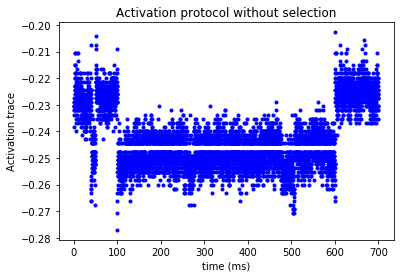

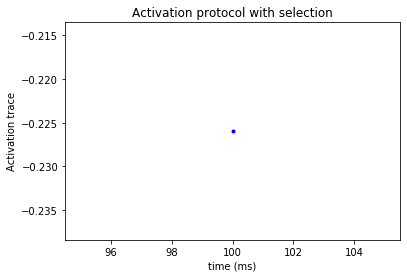

In [37]:
column = 0
title='Activation'
plot_one_trace(data, x_interval, x_start, column,title, with_selection=False)
plot_one_trace(data, x_interval, x_start, column, title, with_selection=True)

In [38]:
def Activation_expo(time, m_tau, m_inf, m_0):
    '''the function to fit to data'''
    # taken from slide 33 wek 3 The hodgkin huxley model
    return m_inf - (m_inf - m_0) * np.exp(-time/ m_tau)
    

In [39]:
def Activation_fit_and_plot (data, x_interval, x_start, column):
    '''fit an exponential and plot the result also print optimal values of parameters'''
    # get time in msec
    time = create_time_vector(data.shape, x_start, x_interval)
    
    # select column in data
    data = data[:,column]

    data, time = select(data,time)
    
    time = time.ravel()
    
    # the assumption of the model is that time starts at 0 !
    time = (time - 100)
    
    ''' fit an exponential curve to data '''
    
    popt, pcov = curve_fit(Activation_expo, time, data)
    perr = np.sqrt(np.diag(pcov))
    
    print('tau')
    print(popt[0])
    print(popt)
    
    plt.figure(figsize=(10,6))
    plt.xlabel('time')
    plt.ylabel('Activation')
    plt.plot(time, data, '.b', label='original data' )
    plt.plot(time, Activation_expo(time, *popt), '-r')#,label='fit: vh=%.3f, slope=%.3f, vh_error=%.3f, slope_error=%.3f' %(*popt,*perr))
    plt.legend()
    plt.show()

We now see that although tau can be calculated for tarce 1,2,3 their tau values are outliers since thay are noisy.

tau
0.20311099052747159
[ 0.20311099 -0.17110842 -0.24722041]


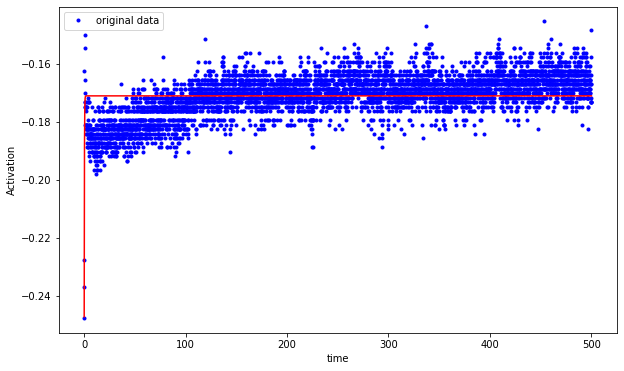

In [47]:
data_path = 'Group7/rCell9699.nwb'

rep = '2'

data, x_interval, x_start = read_trace_from_nwd(data_path, 'Activation', rep)

column = 3
title='Activation'

Activation_fit_and_plot(data, x_interval, x_start, column)

In [48]:
def fit_get_tau(data, x_interval, x_start, column):
    '''calculates the best exponential fit and returns the value of optimal tau'''
    # get time in msec
    time = create_time_vector(data.shape, x_start, x_interval)
    
    # select column in data
    data = data[:,column]

    data, time = select(data,time)
    
    time = time.ravel()
    
    # the assumption of the model is that time starts at 0 !
    time = (time - 100)
    
    ''' fit an exponential curve to data '''
    
    popt, pcov = curve_fit(Activation_expo, time, data)
    perr = np.sqrt(np.diag(pcov))
    
    # just return the tau
    return popt[0]

In [49]:
def plot_tau_clampVoltage(data_path, rep):
    '''plot the tau vs clamp V of the rep indicated'''
    
    # get the data
    data, x_interval, x_start = read_trace_from_nwd(data_path, 'Activation', rep)
    
    # store tau values here
    tau_list = []
    
    # exclude column 0/1/2/3 too noisy !
    # they will give weird tau values
    for column in range(4, data.shape[1]):
        tau = fit_get_tau(data, x_interval, x_start, column)
        tau_list.append(tau)
        
    # plot the tau vs voltages
    
    # for the columns we jumped we put a big value like 100 since this seems a proper upper bound from the data we ploted
    tau_list =  np.append(np.array([100]*4),tau_list)
    
    # define voltages
    v = np.arange(-90, 90, 10)
    
    plt.figure(figsize=(10,6))
    plt.title('Time conatants for the activations of repetition {}'.format(rep))
    plt.xticks(v)
    plt.xlabel('voltage(mv)')
    plt.ylabel('tau(msec)')
    plt.plot(v, tau_list, '.b')
    plt.show()

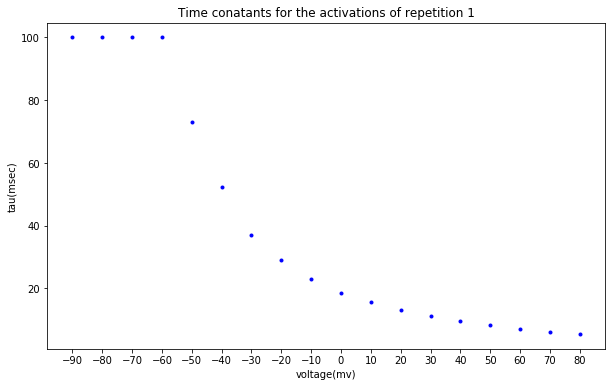

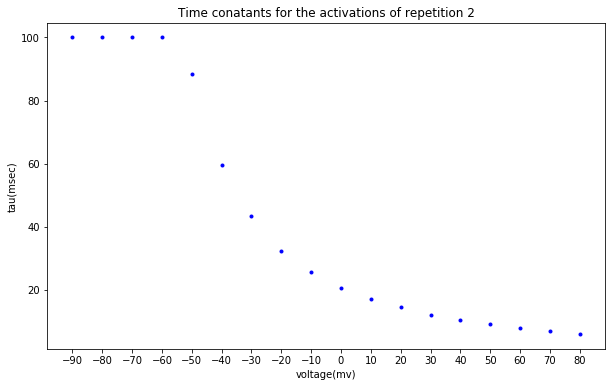

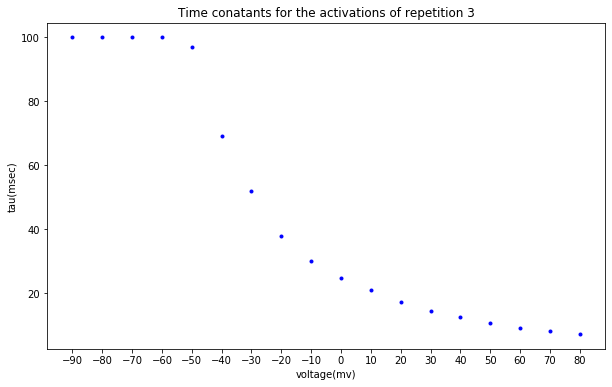

In [50]:
# plot all tau-v curves
data_path = 'Group7/rCell9699.nwb'
for rep in range(1,4):
    plot_tau_clampVoltage(data_path, str(rep))

# Ex3. Find the minimum current amplitud to make the cell fire

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 20 µm of length and diameter, 130 Ω*cm of axial radious and 1.2 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 50 ms delay, 600 ms of duration. The total recording duration of the experiment would be 800 ms and the voltage base -70 mV. Find the minimum ammount of current that has to be injected in this cell in order to make it fire. 
    
<font size = "3">Knowing that in nature square current pulses don't exist. Discuss why finding the minimum ammount of current that makes a neuron fire could be interesting to study the cell. [1 pt]

In [4]:
! nrnivmodl

from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

h.load_file('stdrun.hoc')

# Create a section 
soma = h.Section(name='soma')
soma.L = 20.     # length (µm)
soma.diam = 20.  # diameter (µm)
soma.Ra = 130.0   # axial resistivity (Ω*cm)
soma.cm = 1.2       # capacitance (µF/cm^2)
soma.nseg = 1

# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# INSERT MODELS
soma.insert('K_Ch') ######## This channel dynamic desciption is in K_channel_change_mInf.mod
for seg in soma:
    seg.gKv3bar_K_Ch = 0.01   # Maximal conductance of the potassium channels

soma.insert('Na_Ch')
for seg in soma:
    seg.gNa_Sbar_Na_Ch = 0.09   # Maximal conductance of the sodium channels
    
# Inject a current step into the soma
stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim.delay = 50.   # stim delay (ms)
stim.dur = 600     # stim duration (ms)

# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)


tol = 10**-3
startingAmp = 0.4 # in pA

stim.amp = startingAmp

resultTol = np.Inf

h.finitialize(-70)    # initial voltage 
h.continuerun(800)    # total recording duration

print(np.max(np.array(rec_v)))

#lastAmp = 10000. # in pA

#resultTol = np.Inf

#while resultTol > tol:
    

/home/my_notebooks/Week3
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  K_Channel.lo K_Channel_change_Tau.lo K_Channel_change_mInf.lo Na_Channel.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .l

# Ex4. Modifing K+ channel kinetics

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 18.0 µm of length and diameter, 123 Ω*cm of axial radious and 1.0 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 100 ms delay, 500 ms of duration. The total recording duration of the experiment would be 700 ms and the voltage base -70 mV. 

<font size = "3">Increase and decrase the v_half parameter on the mod file with the K+ channel kinetics for. PLot the resulting voltage curves and the I-V and tau-V curves. 

<font size = "3">Would you be able to explain what is going on? What is the meaning of v_half? Why changing this parameter affects the resultant action potential? [2.5 pts]

/home/In_Silico/InSilicoClass/my_notebooks/Week3
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
K_Channel.mod K_Channel_change_Tau.mod K_Channel_change_mInf.mod Na_Channel.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  K_Channel.lo K_Channel_change_Tau.lo K_Channel_change_mInf.lo Na_Channel.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/pyth

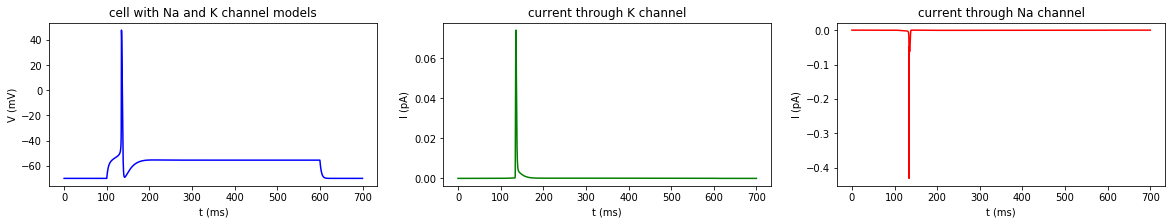

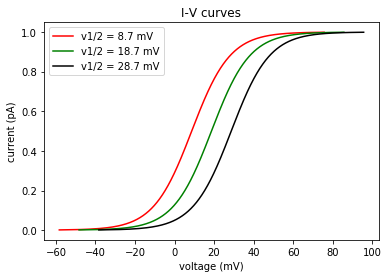

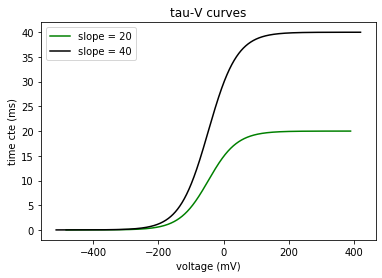

In [1]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Create a section 
soma = h.Section(name='soma')
soma.L = 18.0     # length (µm)
soma.diam = 18.0  # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.cm = 1.0       # capacitance (µF/cm^2)
soma.nseg = 1


# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# INSERT MODELS
soma.insert('K_Ch') ######## This channel dynamic desciption is in K_channel_change_mInf.mod
for seg in soma:
    seg.gKv3bar_K_Ch = 0.01   # Maximal conductance of the potassium channels

soma.insert('Na_Ch')
for seg in soma:
    seg.gNa_Sbar_Na_Ch = 0.09   # Maximal conductance of the sodium channels
    


# Inject a current step into the soma
stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim.delay = 100   # stim delay (ms)
stim.amp = 0.04    # stim amplitude (pA)
stim.dur = 500     # stim duration (ms)


# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v = h.Vector()
rec_v.record(soma(0.5)._ref_v)

# Na current
rec_iNa = h.Vector()
rec_iNa.record(soma(0.5)._ref_ina)
# K current
rec_iK = h.Vector()
rec_iK.record(soma(0.5)._ref_ik)


# Initialize and run a simulation
h.load_file('stdrun.hoc')
h.finitialize(-70)    # initial voltage 
h.continuerun(700)    # total recording duration



# See the voltage curves
fig = plt.figure(figsize=(20,3))
plt.subplot(131)
plt.title('cell with Na and K channel models')
plt.ylabel('V (mV)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_v, 'b')

plt.subplot(132)
plt.title('current through K channel')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_iK, 'g')

plt.subplot(133)
plt.title('current through Na channel')
plt.ylabel('I (pA)')
plt.xlabel('t (ms)')
plt.plot(rec_t,rec_iNa, 'r')



### See the I-V curves

# v_half = 8.7 mV
I3 = np.arange(0, 1.0, 0.001)
V3 = []
for i3 in I3:
    v3 = 8.7 - 9.7*np.log((1/i3)-1)
    V3.append(v3)

# v_half = 18.7 mV
I1 = np.arange(0, 1.0, 0.001)
V1 = []
for i1 in I1:
    v1 = 18.7 - 9.7*np.log((1/i1)-1)
    V1.append(v1)


# v_half = 28.7 mV
I2 = np.arange(0, 1.0, 0.001)
V2 = []
for i2 in I2:
    v2 = 28.7 - 9.7*np.log((1/i2)-1)
    V2.append(v2)

plt.figure()
plt.xlabel('voltage (mV)')
plt.ylabel('current (pA)')
plt.plot(V3, I3, 'r', label='v1/2 = 8.7 mV')
plt.plot(V1, I1, 'g', label='v1/2 = 18.7 mV')
plt.plot(V2, I2, 'k',label='v1/2 = 28.7 mV')
plt.title("I-V curves")
plt.legend()


### See the Tau-V curves

import numpy as np

# slope = 20.0 ms
Tau1 = np.arange(0, 100.0, 0.001)
V1 = []
for t1 in Tau1:
    v1 = -46.56 + (-44.10*np.log((20/t1)-1))
    V1.append(v1)

# slope = 40 ms
Tau2 = np.arange(0, 100.0, 0.001)
V2 = []
for t2 in Tau2:
    v2 = -46.56 + (-44.10*np.log((40/t2)-1))
    V2.append(v2)

plt.figure()
plt.xlabel('voltage (mV)')
plt.ylabel('time cte (ms)')
plt.plot(V1, Tau1, 'g', label='slope = 20')
plt.plot(V2, Tau2, 'k',label='slope = 40')
plt.title("tau-V curves")
plt.legend()

<font size = "3">1 - a.

<font size = "3">2 - V_half is the voltage at half-maximal activation.
 
<font size = "3">3 - b.
